# Markov Decision Processes

This is meant to be a tutorial guide through the structure of a Markov Decision Process (MDP), computing state and action values within a MDP and dealing with partial observability. This is work in progress but will hopefully be completed soon :)

In [85]:
# Import necessary libraries
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

## 1) MDP Structure

A Markov Decision Process (MDP) is based on a **state space**, **action space**, and a **reward function**. Let's go through this via an example called *gridworld* (see Sutton and Barto 2018, p. 60 and following)

### 1.1) State Space

The environment of gridworld is a simple 5x5 grid where every cell reflects an individual **state of the environment**:

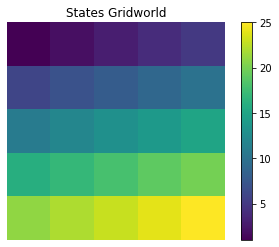

In [86]:
states = np.linspace(1,25,25).reshape(5,5)
#print(states)

plt.imshow(states, cmap='viridis')
plt.colorbar()
plt.axis('off')
plt.title('States Gridworld')
plt.show()

### 1.2) Action Space

An agent can move across this gridworld to collect rewards. There are four **actions**: move North, East, South or West

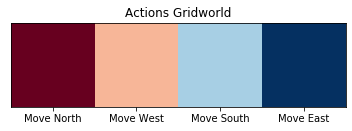

In [87]:
actions = np.linspace(1,4,4).reshape(1,4)
#rint(actions)

plt.imshow(actions, cmap='RdBu')
plt.yticks([])
plt.xticks(np.arange(4), ['Move North', 'Move West', 'Move South','Move East'])
plt.title('Actions Gridworld')
plt.show()

### 1.3) Rewards

Finally, we need to define the **rewards**. Let's assume that 
- Any action that would take the agent off the gridworld results in a reward of -1 and does not change the location of the agent
- Any movement from A (dark yellow below) results in a reward of +10 and moves the agent to A' (bright yellow below)
- Any movement from B (dark green below) results in a reward of +5 and moves the agent to B' (bright green below)
- All other actions result in a reward of 0

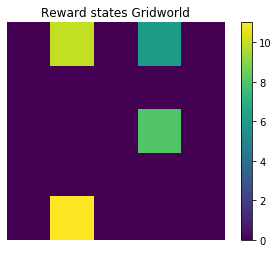

In [88]:
reward_map = np.zeros((5,5))
reward_map[0,1] = 10
reward_map[4,1] = 11
reward_map[0,3] = 6
reward_map[2,3] = 8
                      
plt.imshow(reward_map, cmap='viridis')
plt.colorbar()
plt.axis('off')
plt.title('Reward states Gridworld')
plt.show()

### 1.4) Dynamics

We can now specify the **dynamics** of the MDP. Those dynamics are defined in the function $p$:

$$p(s^\prime,r|s,a) \overset{def}{=} Pr(S_t=s^\prime,R_t=r|S_{t-1}=s, A_{t-1}=a)$$


for all $s^\prime, s \in S$, $r \in R$, and $a \in A(s)$. This is a deterministic function with four arguments: a previous state $s$, an action $a$ at that previous state, a current state $s^\prime$, and a reward $r$ at that current state.

$p$ is a probability function, such that $$\sum_{s^\prime \in S} \sum_{r \in R}p(s^\prime, r|s, a)=1, \forall s \in S, a \in A(s)$$

This is really a crucial definition, because a lot of other notions follow from these dynamics:

The **state transition probabilities** are $$p(s^\prime|s, a) \overset{def}{=}\sum_{r \in R}p(s^\prime, r|s, a)$$

The **expected rewards for state-action pairs** are $$r(s,a)\overset{def}{=}\sum_{r \in R}r\sum_{s^\prime \in S}p(s^\prime, r|s, a)$$

The **expected rewards for state-action-state triples** are $$r(s,a,s^\prime)\overset{def}{=}\sum_{r \in R}r \frac{p(s^\prime, r|s, a)}{p(s^\prime|s, a)}$$

Now let's define the dynamics:

In [173]:
# obtain p - not in the most elegant but hopefully more readable way
n_actions = 4 # move North, West, South or East
n_states = 25 # cells in gridworld
n_rewards = 4 # {-1, 0, 5, 10}
p = np.zeros((n_states,n_rewards,n_states,n_actions))

location_A  = (0,1)
location_Ap = (4,1)
location_B  = (0,3)
location_Bp = (2,3)

for a in range(n_actions):
    for s in range(n_states):
        idx = np.unravel_index(s, states.shape, order='F') # find where state is on 5x5 grid
        # now check if agent wants to move over borders:
        if idx==location_B:
            p[np.ravel_multi_index(location_Bp, states.shape, order='F'),2,s,a] = 1 # agent will move to B' and receive a reward of 5
        elif idx==location_A:
            p[np.ravel_multi_index(location_Ap, states.shape, order='F'),3,s,a] = 1 # agent will move to A' and receive a reward of 10
        elif (idx[0]==0 and a==0) or (idx[1]==states.shape[1]-1 and a==1) or (idx[0]==states.shape[0]-1 and a==2) or (idx[1]==0 and a==3):
            p[s,0,s,a] = 1 # agent will stay where it is and receive a negative reward
        else:
            if a == 0:
                p[np.ravel_multi_index([idx[0]-1,idx[1]], states.shape, order='F'),1,s,a] = 1 # Agent moves North by one field
            elif a == 1:
                p[np.ravel_multi_index([idx[0],idx[1]+1], states.shape, order='F'),1,s,a] = 1 # Agent moves West by one field
            elif a == 2:
                p[np.ravel_multi_index([idx[0]+1,idx[1]], states.shape, order='F'),1,s,a] = 1 # Agent moves South by one field
            elif a == 3:
                p[np.ravel_multi_index([idx[0],idx[1]-1], states.shape, order='F'),1,s,a] = 1 # Agent moves East by one field

This specifies the dynamics of our MDP. This provides all the information we need to infer valuable policies and know about likely transitions in this world.

Based on these dynamics, we can now compute the **transition probabilities** as specified above:

In [174]:
trans_probs = np.sum(p, axis=1)

Now, what happens if we move in the different directions at the top left corner?

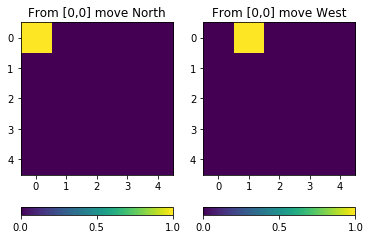

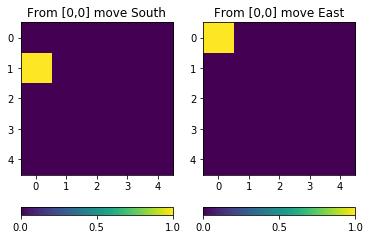

In [178]:
fig = plt.figure() 
a = fig.add_subplot(1, 2, 1)
imgplot = plt.imshow(trans_probs[:,0,0].reshape(states.shape,order='F'), cmap='viridis')
a.set_title('From [0,0] move North')
plt.colorbar(ticks=[0, 0.5, 1], orientation='horizontal')
a = fig.add_subplot(1, 2, 2)
imgplot = plt.imshow(trans_probs[:,0,1].reshape(states.shape,order='F'), cmap='viridis')
a.set_title('From [0,0] move West')
plt.colorbar(ticks=[0, 0.5, 1], orientation='horizontal')
plt.show()

fig = plt.figure() 
a = fig.add_subplot(1, 2, 1)
imgplot = plt.imshow(trans_probs[:,0,2].reshape(states.shape,order='F'), cmap='viridis')
a.set_title('From [0,0] move South')
plt.colorbar(ticks=[0, 0.5, 1], orientation='horizontal')
a = fig.add_subplot(1, 2, 2)
imgplot = plt.imshow(trans_probs[:,0,3].reshape(states.shape,order='F'), cmap='viridis')
a.set_title('From [0,0] move East')
plt.colorbar(ticks=[0, 0.5, 1], orientation='horizontal')
plt.show()

And if we move in the different directions when we are in A? (Remember by design this will always take us to A'!)

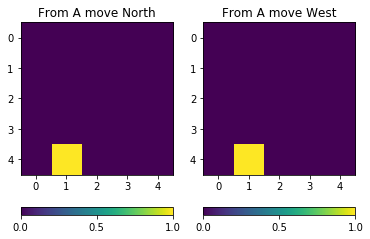

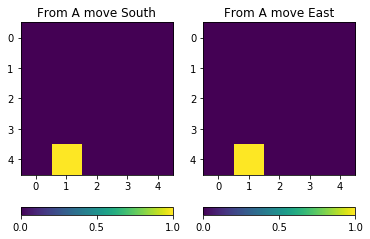

In [179]:
fig = plt.figure() 
a = fig.add_subplot(1, 2, 1)
imgplot = plt.imshow(trans_probs[:,5,0].reshape(states.shape,order='F'), cmap='viridis')
a.set_title('From A move North')
plt.colorbar(ticks=[0, 0.5, 1], orientation='horizontal')
a = fig.add_subplot(1, 2, 2)
imgplot = plt.imshow(trans_probs[:,5,1].reshape(states.shape,order='F'), cmap='viridis')
a.set_title('From A move West')
plt.colorbar(ticks=[0, 0.5, 1], orientation='horizontal')
plt.show()

fig = plt.figure() 
a = fig.add_subplot(1, 2, 1)
imgplot = plt.imshow(trans_probs[:,5,2].reshape(states.shape,order='F'), cmap='viridis')
a.set_title('From A move South')
plt.colorbar(ticks=[0, 0.5, 1], orientation='horizontal')
a = fig.add_subplot(1, 2, 2)
imgplot = plt.imshow(trans_probs[:,5,3].reshape(states.shape,order='F'), cmap='viridis')
a.set_title('From A move East')
plt.colorbar(ticks=[0, 0.5, 1], orientation='horizontal')
plt.show()

We can also obtain the **expected rewards for state-action pairs**:

In [194]:
# first, sum over all possible next states:
p_rsa = np.sum(p, axis=0)

# then, sum over all rewards weighted by their reward value
# rewards are -1 for attempting to leave the grid, 0 anywhere except at B (5 for every action) and A (10 for every action)
# Let's loop over it for illustration purposes:
r_sa = -1 * p_rsa[0,:,:] + 0 * p_rsa[1,:,:] + 5 * p_rsa[2,:,:] + 10 * p_rsa[3,:,:]

So how good are the different actions in the different states?

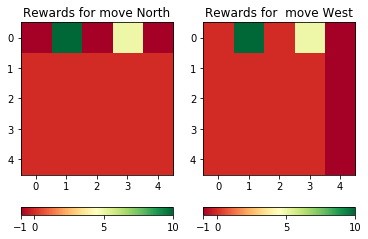

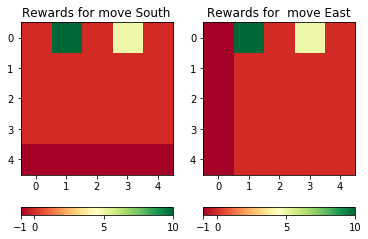

In [193]:
fig = plt.figure() 
a = fig.add_subplot(1, 2, 1)
imgplot = plt.imshow(r_sa[:,0].reshape(states.shape,order='F'), cmap='RdYlGn')
a.set_title('Rewards for move North')
plt.colorbar(ticks=[-1, 0, 5, 10], orientation='horizontal')
a = fig.add_subplot(1, 2, 2)
imgplot = plt.imshow(r_sa[:,1].reshape(states.shape,order='F'), cmap='RdYlGn')
a.set_title('Rewards for  move West')
plt.colorbar(ticks=[-1, 0, 5, 10], orientation='horizontal')
plt.show()

fig = plt.figure() 
a = fig.add_subplot(1, 2, 1)
imgplot = plt.imshow(r_sa[:,2].reshape(states.shape,order='F'), cmap='RdYlGn')
a.set_title('Rewards for move South')
plt.colorbar(ticks=[-1, 0, 5, 10], orientation='horizontal')
a = fig.add_subplot(1, 2, 2)
imgplot = plt.imshow(r_sa[:,3].reshape(states.shape,order='F'), cmap='RdYlGn')
a.set_title('Rewards for  move East')
plt.colorbar(ticks=[-1, 0, 5, 10], orientation='horizontal')
plt.show()

And we can also get the **expected rewards for state-action-state triples**:

In [204]:
# Divide Transitions for a given reward by transition probabilities (adding a small number to avoid division by zero)
# Then sum weighted by reward values
# Rewards are -1 for attempting to leave the grid, 0 anywhere except at B (5 for every action) and A (10 for every action)
# Let's loop over it for illustration purposes:
r_sas = -1 * np.divide(p[:,0,:,:],trans_probs+(1.e-20)) + 0 * np.divide(p[:,1,:,:],trans_probs+(1.e-20)) + \
         5 * np.divide(p[:,2,:,:],trans_probs+(1.e-20)) + 10 * np.divide(p[:,3,:,:],trans_probs+(1.e-20))

This is helpful, because it provides information about likely transitions within our *MDP reward structure*.

For example, we can now repeat the transition prob plots above and also obtain info about expected rewards in those transitions:

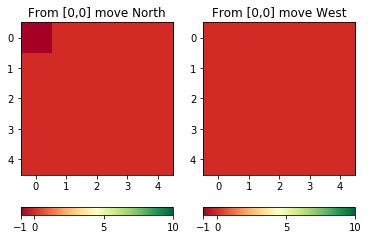

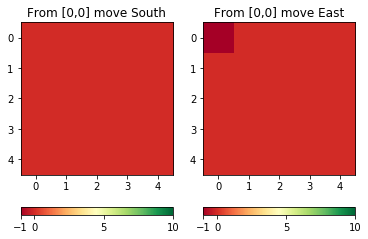

In [214]:
fig = plt.figure() 
a = fig.add_subplot(1, 2, 1)
imgplot = plt.imshow(r_sas[:,0,0].reshape(states.shape,order='F'), cmap='RdYlGn', vmin=-1, vmax=10)
a.set_title('From [0,0] move North')
plt.colorbar(ticks=[-1, 0, 5, 10], orientation='horizontal')
a = fig.add_subplot(1, 2, 2)
imgplot = plt.imshow(r_sas[:,0,1].reshape(states.shape,order='F'), cmap='RdYlGn', vmin=-1, vmax=10)
a.set_title('From [0,0] move West')
plt.colorbar(ticks=[-1, 0, 5, 10], orientation='horizontal')
plt.show()

fig = plt.figure() 
a = fig.add_subplot(1, 2, 1)
imgplot = plt.imshow(r_sas[:,0,2].reshape(states.shape,order='F'), cmap='RdYlGn', vmin=-1, vmax=10)
a.set_title('From [0,0] move South')
plt.colorbar(ticks=[-1, 0, 5, 10], orientation='horizontal')
a = fig.add_subplot(1, 2, 2)
imgplot = plt.imshow(r_sas[:,0,3].reshape(states.shape,order='F'), cmap='RdYlGn', vmin=-1, vmax=10)
a.set_title('From [0,0] move East')
plt.colorbar(ticks=[-1, 0, 5, 10], orientation='horizontal')
plt.show()

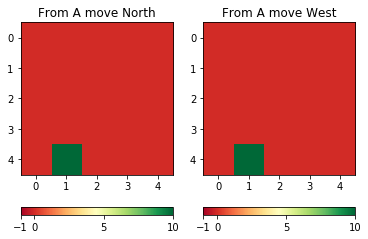

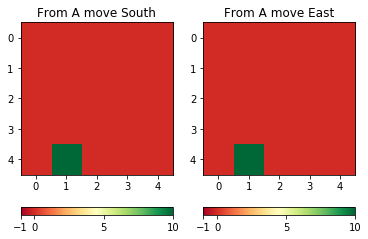

In [215]:
fig = plt.figure() 
a = fig.add_subplot(1, 2, 1)
imgplot = plt.imshow(r_sas[:,5,0].reshape(states.shape,order='F'), cmap='RdYlGn', vmin=-1, vmax=10)
a.set_title('From A move North')
plt.colorbar(ticks=[-1, 0, 5, 10], orientation='horizontal')
a = fig.add_subplot(1, 2, 2)
imgplot = plt.imshow(r_sas[:,5,1].reshape(states.shape,order='F'), cmap='RdYlGn', vmin=-1, vmax=10)
a.set_title('From A move West')
plt.colorbar(ticks=[-1, 0, 5, 10], orientation='horizontal')
plt.show()

fig = plt.figure() 
a = fig.add_subplot(1, 2, 1)
imgplot = plt.imshow(r_sas[:,5,2].reshape(states.shape,order='F'), cmap='RdYlGn', vmin=-1, vmax=10)
a.set_title('From A move South')
plt.colorbar(ticks=[-1, 0, 5, 10], orientation='horizontal')
a = fig.add_subplot(1, 2, 2)
imgplot = plt.imshow(r_sas[:,5,3].reshape(states.shape,order='F'), cmap='RdYlGn', vmin=-1, vmax=10)
a.set_title('From A move East')
plt.colorbar(ticks=[-1, 0, 5, 10], orientation='horizontal')
plt.show()

This concludes the exploration of MDP dynamics, which we can use to compute state and action values and optimal policies.